## Plotting unitary Fermi gas quantities
Plotting quantities using tabulated data and code from Tilman Enss

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

### Contact density
From Enss, Haussmann, Zwerger 2011?

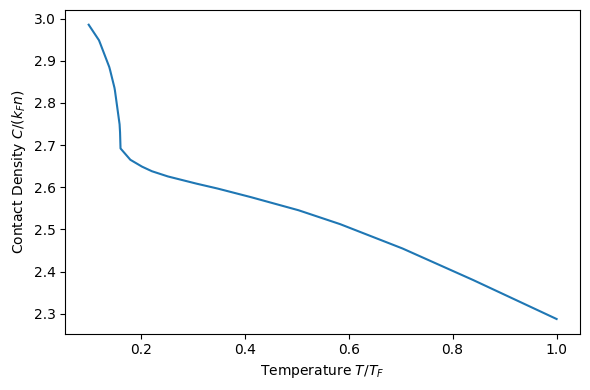

In [ ]:
from amo.luttinger_ward_calculations import contact_density

ToTFs = np.linspace(0.1, 1.0, 1000)

xlabel = r'Temperature $T/T_F$'
ylabel = r'Contact Density $C/(k_F n)$'

fig, ax = plt.subplots(figsize=(6,4))

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, contact_density(ToTFs))

fig.tight_layout()

plt.show()


### Trap averaged-contact

In [11]:
from amo.unitary_fermi_gas import calc_contact
import pandas as pd

df = pd.read_csv(os.path.join('..', 'data', 'luttward-thermodyn.txt'), skiprows=4, sep=' ')
# df[ylabel] = df['s/(k_B*n)'] * 3*np.pi**2  # contact density c/(k_F n) = C/k_F^4 * (3 pi^2)

df = df[df['T/T_F'] < 1.2]
df = df[df['T/T_F'] > 0.18]

ToTFs = df['T/T_F']
print(ToTFs)

# ToTFs = np.linspace(0.1, 1.0, 50)
EF = 10e3  # Hz
barnu = 300  # Hz

Cs = np.array([calc_contact(*arg) for arg in zip(ToTFs, 
        EF * np.ones_like(ToTFs), barnu * np.ones_like(ToTFs))])

Ss = df['s/(k_B*n)']


14    0.201
15    0.220
16    0.250
17    0.300
18    0.340
19    0.400
20    0.500
21    0.580
22    0.700
23    0.830
24    1.000
Name: T/T_F, dtype: float64


f:\GitHub\ChiPyLab\amo\unitary_fermi_gas.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  return (4*pi)/((3*pi**2)* eos_ufg(betamu))**(2/3)


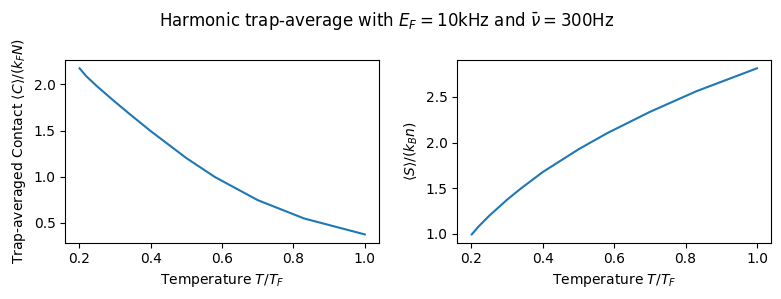

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle(r"Harmonic trap-average with $E_F=$" + f"{EF/1e3:.0f}kHz" \
             + r" and $\bar\nu=$" + f"{barnu:.0f}Hz")

## Trap-averaged contact
ax = axs[0]
xlabel = r'Temperature $T/T_F$'
ylabel = r'Trap-averaged Contact $\langle C \rangle/(k_F N)$'

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, Cs)


## Trap-averaged susceptibility
ax = axs[1]
ylabel = r'$\langle S \rangle/(k_B n)$'

ax.set(xlabel=xlabel, ylabel=ylabel)
ax.plot(ToTFs, Ss)


fig.tight_layout()

plt.show()